## Notebook summary

This notebook pulls all flooding related 311 records from NYC's API and cleans them. It combines this data with flood risk boundaries from FEMA and zipcode shapefiles to compute important spatial statistics and create the necessary spatial files to map the 311 data. The analysis and spatial files are combined into a map-based narrative that can be found here: https://arcg.is/HLfnv0

In [30]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import geopandas as gpd
import mapclassify

### Define helpful functions

In [31]:
def clean_311_dtypes(df_):
    '''
    Takes the 311 raw data as a pandas dataframe and returns a cleaned version of the dataframe
    '''
    #Format datatypes
    date_cols = ['created_date','closed_date', 'due_date', 'resolution_action_updated_date']
    for date_col in date_cols:
        df_[date_col] = pd.to_datetime(df_[date_col], errors='coerce')

    #Make complaints all uppercase
    df_['complaint_type'] = df_['complaint_type'].str.upper()
    df_['descriptor'] = df_['descriptor'].str.upper()

    #Load zipcodes as strings
    df_['incident_zip'].fillna(-1, inplace = True)
    df_['incident_zip'] = df_['incident_zip'].astype('int').astype('str')
    df_['incident_zip'].replace('-1', 'NaN', inplace = True)
    
    #Strip whitespace at beginning and end of all columns with text datatype
    df_text_object = df_.select_dtypes(include='object')
    for text_col in df_text_object.columns:
        df_[text_col] = df_[text_col].str.strip()
    
    return df_

def to_epsg_4326(gdf):
    '''
    Checks CRS of geodataframe and convert it to epsg_4326 if not already that
    
    Note: gdf.crs['init'] will now error because of package updates
    Use gdf.crs- https://geopandas.org/projections.html
    '''
    current_crs = gdf.crs
    if current_crs == 'epsg:4326':
        print('CRS was already epsg:4326')
        return gdf
    else:
        print("Current CRS was {}. Reprojecting to epsg:4326.".format(current_crs))
        reprojected_gdf = gdf.to_crs(epsg=4326)
        return reprojected_gdf
        

### Load necessary shapefiles

In [3]:
#Load NYC boroughs shapefile clipped at shoreline
bb = pd.read_json( 'https://data.cityofnewyork.us/resource/7t3b-ywvw.json' )
bb['features'] = bb['the_geom'].apply(lambda x: {'geometry': x, 'properties': {}}) #Extract geo
bb2 = gpd.GeoDataFrame.from_features( bb['features'] )
boroughs_gdf = bb.set_geometry(bb2.geometry)#Assign Geometry
boroughs_gdf = boroughs_gdf[['boro_code','boro_name','geometry']] #Clean
boroughs_gdf = boroughs_gdf.set_crs(epsg=4326) #Data is already in 4326


In [4]:
#Load NYC zip code boundary shapefiles - SRC: https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u
zipcode_gdf = gpd.read_file('raw_data/nyc_zipcode_boundaries/ZIP_CODE_040114.shp')
zipcode_gdf = to_epsg_4326(zipcode_gdf)

#Dissolve polygons into multipolygons for non-continuous zip codes (consolidates repeated zip code rows)
print('Consolidating the below zipcodes...')
display(zipcode_gdf[zipcode_gdf['ZIPCODE'].duplicated(keep=False)].sort_values('ZIPCODE'))
zipcode_gdf = zipcode_gdf.dissolve(by='ZIPCODE').reset_index()

#Throw out the tiny zipcodes in manhattan that have population 0
zipcode_gdf = zipcode_gdf[zipcode_gdf['POPULATION']!=0]
zipcode_gdf.head()

Current CRS was epsg:2263. Reprojecting to epsg:4326.
Consolidating the below zipcodes...


,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
109,10004,0,New York,2187.0,1.202708e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.04166 40.69645, -74.04237 40.697..."
114,10004,0,New York,2187.0,6.707080e+05,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.04699 40.69012, -74.04700 40.690..."
106,10004,0,New York,2187.0,4.002521e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.01101 40.70622, -74.00997 40.705..."
113,10004,0,New York,2187.0,7.679616e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-74.02418 40.68392, -74.02425 40.683..."
253,10035,0,New York,34884.0,2.349487e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.92742 40.79839, -73.92737 40.798..."
49,10035,0,New York,34884.0,1.544566e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.93326 40.80724, -73.93319 40.807..."
245,10047,1,New York,0.0,1.014978e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.98633 40.73958, -73.98635 40.739..."
246,10047,1,New York,0.0,1.014978e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.98633 40.73958, -73.98635 40.739..."
241,10196,1,New York,0.0,3.154825e+03,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.98133 40.75673, -73.98138 40.756..."
240,10196,1,New York,0.0,3.250244e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((-73.98243 40.75680, -73.98213 40.757..."


,ZIPCODE,geometry,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN
0,00083,"POLYGON ((-73.94922 40.79691, -73.94932 40.796...",0,Central Park,25.0,3.830099e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0
1,10001,"POLYGON ((-74.00827 40.75259, -74.00819 40.752...",0,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0
2,10002,"POLYGON ((-73.97442 40.73642, -73.97445 40.736...",0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0
3,10003,"POLYGON ((-73.97986 40.73497, -73.98028 40.734...",0,New York,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0
4,10004,"MULTIPOLYGON (((-74.02418 40.68392, -74.02425 ...",0,New York,2187.0,4.002521e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0


In [5]:
#Load FEMA's most recent flood hazard dataset (from Prelminary Flood Insurance Rate Map - PFIRM)
PFIRM_gdf = gpd.read_file("raw_data/proposed_FIRM_NYC_2015/s_fld_haz_ar.shp")

#Reproject
PFIRM_gdf = to_epsg_4326(PFIRM_gdf)

PFIRM_gdf['RiskGroup'] = None
PFIRM_gdf.loc[ PFIRM_gdf['FLD_ZONE'].isin( ['A', 'AE', 'AO', 'VE'] ), 'RiskGroup' ] = 'High' #High Risk Groups
PFIRM_gdf.loc[ PFIRM_gdf['FLD_ZONE'] == '0.2 PCT ANNUAL CHANCE FLOOD HAZARD', 'RiskGroup' ] = 'Moderate' #Moderate Risk Group
PFIRM_gdf = PFIRM_gdf.dropna(axis=1,how='all') #Remove empty columns
PFIRM_gdf.drop('geometry',axis=1).head() #Plotting without the geometry column for simplicity


Current CRS was epsg:2263. Reprojecting to epsg:4326.


,FLD_AR_ID,FLD_ZONE,FLOODWAY,SFHA_TF,STATIC_BFE,V_DATUM,DEPTH,LEN_UNIT,VELOCITY,BFE_REVERT,DEP_REVERT,SOURCE_CIT,RiskGroup
0,81,AE,None,T,13.0,NAVD88,-9999.0,FEET,-9999.0,-9999.0,-9999.0,STUDY4,High
1,82,X,None,F,-9999.0,None,-9999.0,None,-9999.0,-9999.0,-9999.0,STUDY4,None
2,83,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,-9999.0,-9999.0,STUDY4,Moderate
3,84,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,-9999.0,-9999.0,STUDY4,Moderate
4,85,0.2 PCT ANNUAL CHANCE FLOOD HAZARD,None,F,-9999.0,None,-9999.0,None,-9999.0,-9999.0,-9999.0,STUDY4,Moderate


In [6]:
#Export a version of the PFIRM where all the subparts of the flood risk group have been merged together into one multipolygon
PFIRM_gdf.dissolve(by='RiskGroup').to_file("processed_data/PFIRM.geojson", driver='GeoJSON')

### Load the 311 flooding data
Use the below variable to specify whether you want to use the API or load the data that has already been pulled via the API and saved as CSV (takes a long time to pull all the records from the API)

In [7]:
use_API = False

In [8]:
if use_API:
    #Iteration parameters to extract all records assigned to DEP
    current_date='2020-09-30T00:00:00'
    number_rows = 99999999999999
    chunk = 50000
    max_iter = round(number_rows/chunk)

    #Iterate using API
    chunks=[]
    for i in range(max_iter):
        offset = i*chunk
        url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json?agency=DEP&$where=created_date<'{}'&$limit={}&$offset={}&$$app_token=Ah0ok4sAd9RCyenJepmKahuG9".format(current_date, chunk, offset)
        print('Iter: {}'.format(i))
        payload = {}
        headers= {}

        response = requests.request("GET", url, headers=headers, data = payload)
        if (response.status_code == 200) & ('[]' not in response.text):
            df_311_chunk = pd.read_json(response.text)
            chunks.append(df_311_chunk)
        else:
            break
            
        #Concat chunks into one dataset
        df_311 = pd.concat(chunks, sort = False)

        #Clean data
        df_311 = clean_311_dtypes(df_311)
        display(df_311.head(2))

        #Check for duplicates in case the offsets were inclusive of the domain and are overlapping
        df_311_no_duplicates = df_311.drop_duplicates(subset = 'unique_key')

        if df_311_no_duplicates.shape[0] == df_311.shape[0]:
            df_311 = df_311_no_duplicates.copy()
            del df_311_no_duplicates

        print('Number of records assigned to the DEP: {}'.format(df_311.shape[0]))

        flood_records = df_311[(df_311['descriptor'].str.contains('FLOOD')) & (~df_311['descriptor'].isna())]
        flood_records.groupby(['complaint_type','descriptor'])['unique_key'].count()

        flood_records.to_csv('raw_data/flood_records_311.csv')
else: #Load from csv
    #Load in the flood records from csv
    flood_records = pd.read_csv("raw_data/flood_records_311.csv")
    flood_records = clean_311_dtypes(flood_records)

    #Drop unamed columns
    flood_records = flood_records[[column for column in flood_records.columns if 'Unnamed' not in column]]

/usr/local/anaconda3/envs/carto/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Prepare the flood records for analysis and mapping

In [9]:
#Drop the records that are duplicate complaints according to the resolution description
flood_records = flood_records[~flood_records['resolution_description'].isna()]
flood_records['resolution_description'] = flood_records['resolution_description'].str.upper()
flood_records[flood_records['resolution_description'].str.contains('DUPLICATE')]['resolution_description'].unique()

array(['THE DEPARTMENT OF ENVIRONMENTAL PROTECTION DETERMINED THAT THIS COMPLAINT IS A DUPLICATE OF A PREVIOUSLY FILED COMPLAINT. THE ORIGINAL COMPLAINT IS BEING ADDRESSED.'],
      dtype=object)

In [10]:
#Throw out those that are missing lat/long
flood_records = flood_records[~((flood_records['latitude'].isna())|(flood_records['longitude'].isna()))]
flood_gdf = gpd.GeoDataFrame(flood_records, geometry=gpd.points_from_xy(flood_records['longitude'], flood_records['latitude']), crs="epsg:4326")


### Look at how complaints have varied over time

<AxesSubplot:xlabel='created_year'>

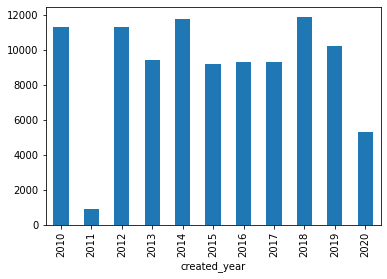

In [11]:
flood_gdf['created_year'] = pd.DatetimeIndex(flood_records['created_date']).year
flood_gdf.groupby('created_year')['unique_key'].count().plot.bar()

### Subset out last five years of 311 complaints

In [13]:
last_five_years = flood_gdf[flood_gdf['created_year']>=2015]

### Export five year view of raw 311 records as both geojson and shapefile to load into ESRI
Sometimes one format loads better when the data is large

In [14]:
# last_five_years[['created_year', 'incident_zip', 'geometry']].to_file('processed_data/all_311_2015_2020.geojson',  driver='GeoJSON')
# last_five_years[['created_year', 'incident_zip', 'geometry']].to_file('processed_data/all_311_2015_2020.shp')

### Calculate spatial stats for map narrative

#### Percent of complaints in the past 5 years that have been in the high risk flood area as defined by FEMA's PFIRM

In [15]:
PFIRM_gdf['in_PFIRM'] = 1
high_risk_complaints = gpd.sjoin(last_five_years, PFIRM_gdf[PFIRM_gdf['RiskGroup']=='High'], op='intersects', how = 'inner')
print("{}% of the 311 complaints between 2015-2020 fall within the high risk area of the PFIRM".format(high_risk_complaints.shape[0]/last_five_years.shape[0]*100))

13.671436333997464% of the 311 complaints between 2015-2020 fall within the high risk area of the PFIRM


#### Area of the high and moderate flood risk areas according to the PFIRM (in square miles)
Used EPSG 2263 because it preserves area relatively well in NYC and gives an area in square ft (https://nycitymap.wordpress.com/tag/coordinate-systems/)

In [16]:
#Calculate the area of the high and moderate flood risk areas according to the PFIRM (in square miles)
PFIRM_gdf.dissolve(by='RiskGroup').to_crs(epsg=2263).area/27878400

RiskGroup
High        80.746974
Moderate    19.890681
dtype: float64

### Examine distribution of 311 complaints grouped by zipcode
Helps decide where to bin data for coloring in choropleth map

The threshold of the outliers is 798


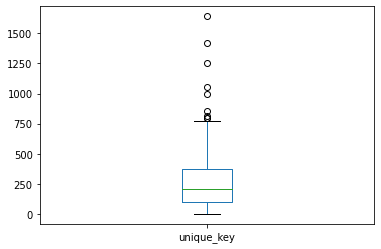

In [32]:
with_zipcode_flood_gdf = last_five_years[last_five_years['incident_zip']!='NaN']
# with_zipcode_flood_gdf = flood_gdf[flood_gdf['incident_zip']!='NaN']
_, boxplot = with_zipcode_flood_gdf.groupby(['incident_zip'])['unique_key'].count().plot.box(return_type='both')
outliers = [flier.get_ydata() for flier in boxplot["fliers"]]
threshold = min(outliers[0])
print("The threshold of the outliers is {}".format(threshold))

### Visualize the zip codes that are outliers according to the total number of complaints that were filed (unnormalized)


9628

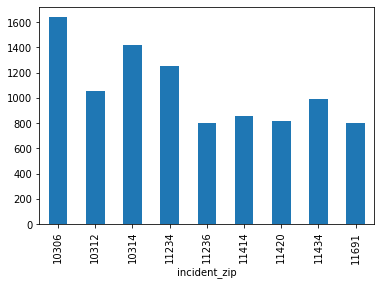

In [33]:
grouped_by_zip = with_zipcode_flood_gdf.groupby(['incident_zip'])['unique_key'].count()
grouped_by_zip_outliers = grouped_by_zip[grouped_by_zip>=threshold]
grouped_by_zip_outliers.plot.bar()

#Extract the zipcodes where there are disproportionately more floods
high_density_complaints = with_zipcode_flood_gdf[with_zipcode_flood_gdf['incident_zip'].isin(grouped_by_zip_outliers.index)]
high_density_complaints.shape[0]

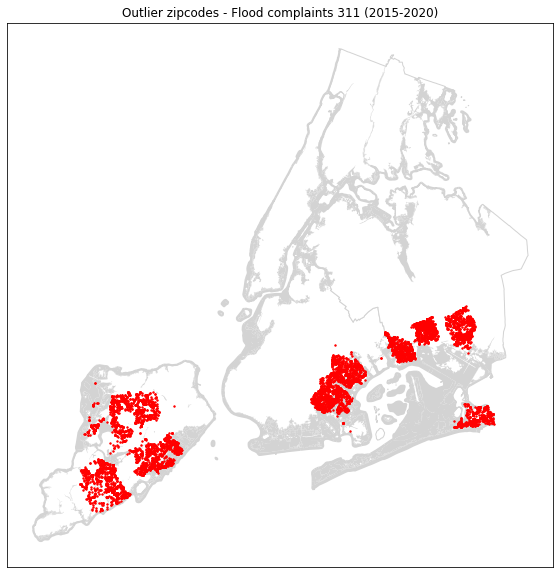

In [34]:
base = boroughs_gdf.plot(color='white', edgecolor='lightgray', figsize = (10,10))
PFIRM_gdf[~PFIRM_gdf['RiskGroup'].isna()].plot(ax=base, color='lightgray')
high_density_complaints.plot(ax=base,
    color='red',
    marker = 'o',
    markersize = 2)
base.tick_params(left=False , bottom = False , labelleft=False, labelbottom=False)
base.set_title('Outlier zipcodes - Flood complaints 311 (2015-2020)')
plt.show()


### Visualize the zip codes based on the number of complaints filed per square mile (Normalized)
This is more meaningful, especially when combined with population density (as the ESRI map does)

In [35]:
#Merge in zipcode boundaries to be able to get the area of each zip code
grouped_by_zip_gdf = zipcode_gdf.merge(grouped_by_zip.reset_index(), left_on='ZIPCODE', right_on = 'incident_zip', how='right')
if grouped_by_zip_gdf[grouped_by_zip_gdf['ZIPCODE'].isna()].empty:
    print("There is a problem merging in shapefiles")

grouped_by_zip_gdf = zipcode_gdf.merge(grouped_by_zip.reset_index(), left_on='ZIPCODE', right_on = 'incident_zip', how='left')
grouped_by_zip_gdf.rename(columns={'unique_key':'num_complaints'}, inplace = True)
grouped_by_zip_gdf['num_complaints'].fillna(0, inplace = True)

#Normalize number of complaints by population and land area
grouped_by_zip_gdf['num_complaints_per_capita'] = grouped_by_zip_gdf['num_complaints']/grouped_by_zip_gdf['POPULATION']
grouped_by_zip_gdf['zipcode_area_square_miles'] = grouped_by_zip_gdf.to_crs(epsg=2263).area/27878400
grouped_by_zip_gdf['num_complaints_per_square_mile'] = grouped_by_zip_gdf['num_complaints']/grouped_by_zip_gdf['zipcode_area_square_miles']
grouped_by_zip_gdf['people_per_square_mile'] = grouped_by_zip_gdf['POPULATION']/grouped_by_zip_gdf['zipcode_area_square_miles']

457.183333297141


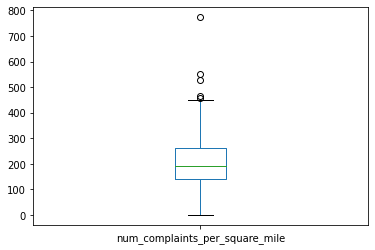

In [36]:
_, boxplot = grouped_by_zip_gdf['num_complaints_per_square_mile'].plot.box(return_type='both')
outliers = [flier.get_ydata() for flier in boxplot["fliers"]]
threshold = min(outliers[0])
print(threshold)

1961


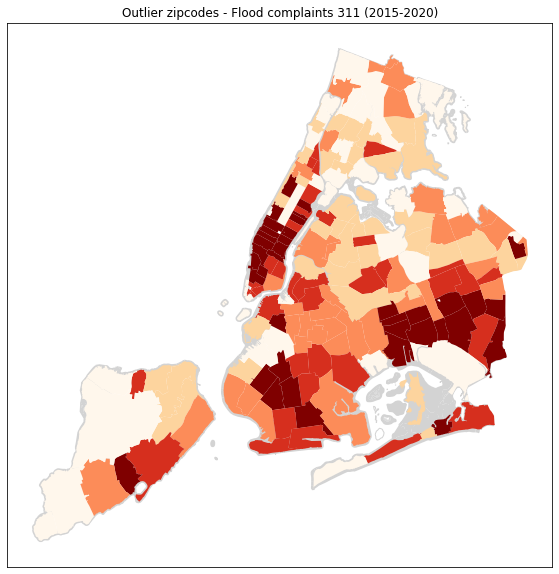

In [37]:
#Extract and map
#Extract the zipcodes where there are disproportionately more floods
grouped_by_zip_outliers = grouped_by_zip_gdf[grouped_by_zip_gdf['num_complaints_per_square_mile']>=threshold]
high_density_complaints = with_zipcode_flood_gdf[with_zipcode_flood_gdf['incident_zip'].isin(grouped_by_zip_outliers['incident_zip'])]
print(high_density_complaints.shape[0])

#Map

base = boroughs_gdf.plot(color='white', edgecolor='lightgray', figsize = (10,10))
PFIRM_gdf[~PFIRM_gdf['RiskGroup'].isna()].plot(ax=base, color='lightgray')
grouped_by_zip_gdf.plot(ax=base,
    column='num_complaints_per_square_mile',
    cmap='OrRd',
    scheme='quantiles')
base.tick_params(left=False , bottom = False , labelleft=False, labelbottom=False)
base.set_title('Outlier zipcodes - Flood complaints 311 (2015-2020)')
plt.show()


### Export 5 year view of 311 records grouped by zip code with zip code shapes to geojson to load into ESRI

In [38]:
grouped_by_zip_gdf.to_file('processed_data/complaints_by_zip_2015_2020.geojson', driver='GeoJSON')